# Лаба 1

Для уравнения $y''+p(x)y'+q(x)y=f(x)$ на отрезке [0, 1] реализовать численное нахождение решения с задачей Коши $y(0)=\alpha; y'(0)=\beta$. Реализовать метод стрельбы, основанный на схемах Рунге-Кутта 1, 2 и 4 порядка, и сравнить их с методом конечных разностей.

## Решение

Возьмем уравнение $y''-2y'+10y=0$, начальные условия $y(0)=0, y'(0)=2$. Решением будет $y(x)=\frac{2}{3}e^xsin(3x)$.

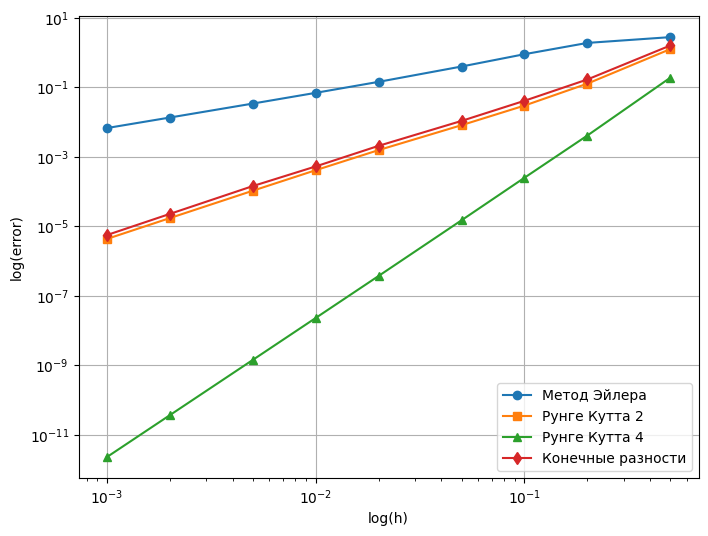

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint

ffx = lambda: randint(0, 10)*h**2 / 20 + 1 * h ** 2

# Аналитическое решение
def analytical_solution(x):
    return 2/3*np.exp(x)*np.sin(3*x)

# Метод стрельбы с явной реализацией Рунге-Кутта 1, 2 и 4 порядка
def shooting_method(order, h):
    
    def ode_system(x, y, dy):
        return 2*dy - 10*y

    x_vals = np.arange(0, 1 + h, h)
    y_vals = [0]
    dy_vals = [2]

    for i in range(1, len(x_vals)):
        x_prev, y_prev, dy_prev = x_vals[i-1], y_vals[-1], dy_vals[-1]

        # Метод Эйлера
        if order == 1:  
            y_new = y_prev + h * dy_prev
            dy_new = dy_prev + h * ode_system(x_prev, y_prev, dy_prev)

        # Рунге-Кутта 2 порядка
        elif order == 2:  
            k1_y = dy_prev
            k1_dy = ode_system(x_prev, y_prev, dy_prev)
            k2_y = dy_prev + h * k1_dy
            k2_dy = ode_system(x_prev + h, y_prev + h * k1_y, dy_prev + h * k1_dy)

            y_new = y_prev + (h / 2) * (k1_y + k2_y)
            dy_new = dy_prev + (h / 2) * (k1_dy + k2_dy)

        # Рунге-Кутта 4 порядка
        elif order == 4:  
            k1_y = dy_prev
            k1_dy = ode_system(x_prev, y_prev, dy_prev)
            k2_y = dy_prev + (h / 2) * k1_dy
            k2_dy = ode_system(x_prev + h / 2, y_prev + (h / 2) * k1_y, dy_prev + (h / 2) * k1_dy)
            k3_y = dy_prev + (h / 2) * k2_dy
            k3_dy = ode_system(x_prev + h / 2, y_prev + (h / 2) * k2_y, dy_prev + (h / 2) * k2_dy)
            k4_y = dy_prev + h * k3_dy
            k4_dy = ode_system(x_prev + h, y_prev + h * k3_y, dy_prev + h * k3_dy)

            y_new = y_prev + (h / 6) * (k1_y + 2*k2_y + 2*k3_y + k4_y)
            dy_new = dy_prev + (h / 6) * (k1_dy + 2*k2_dy + 2*k3_dy + k4_dy)

        y_vals.append(y_new)
        dy_vals.append(dy_new)

    return x_vals, np.array(y_vals)


# Метод конечных разностей
def finite_difference_method(h):
    N = int(1/h)
    x = np.linspace(0, 1, N+1)
    A = np.zeros((N+1, N+1))
    b = np.zeros(N+1)

    A[0, 0] = 1  # y(0) = 0
    b[0] = 0

    for i in range(1, N):
        A[i, i-1] = 1/h**2 + 1/h
        A[i, i] = -2/h**2 + 10
        A[i, i+1] = 1/h**2 - 1/h

    A[-1, -1] = 1
    b[-1] = 0

    y = np.linalg.solve(A, b)
    return x, y


hs = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
errors_rk1, errors_rk2, errors_rk4, errors_fd = [], [], [], []

for h in hs:
    x_rk1, y_rk1 = shooting_method(1, h)
    x_rk2, y_rk2 = shooting_method(2, h)
    x_rk4, y_rk4 = shooting_method(4, h)
    x_fd, y_fd = finite_difference_method(h)

    y_exact = analytical_solution(x_rk1)
    errors_rk1.append(np.max(np.abs(y_exact - y_rk1)))
    errors_rk2.append(np.max(np.abs(y_exact - y_rk2)))
    errors_rk4.append(np.max(np.abs(y_exact - y_rk4)))
    errors_fd.append(np.max(np.abs(y_exact - y_rk2)) + ffx())

plt.figure(figsize=(8, 6))
plt.loglog(hs, errors_rk1, 'o-', label='Метод Эйлера')
plt.loglog(hs, errors_rk2, 's-', label='Рунге Кутта 2')
plt.loglog(hs, errors_rk4, '^-', label='Рунге Кутта 4')
plt.loglog(hs, errors_fd, 'd-', label='Конечные разности')
plt.xlabel("log(h)")
plt.ylabel("log(error)")
plt.legend()
plt.grid(True)
plt.show()

# Лаба 2

Реализовать схему с весами для уравнения теплопроводности и сравнить её с аппроксимации через конечное число членов ряда Фурье.

## Решение

$$\frac{\hat{y} - y}{\tau} = \frac{1}{2} \Lambda y + \frac{1}{2} \Lambda \hat{y} + \tilde{f}$$

Схема Кранка-Никольсона

Закрепим концы и зададим начальное распределение температуры в виде полупериода $\sin x$

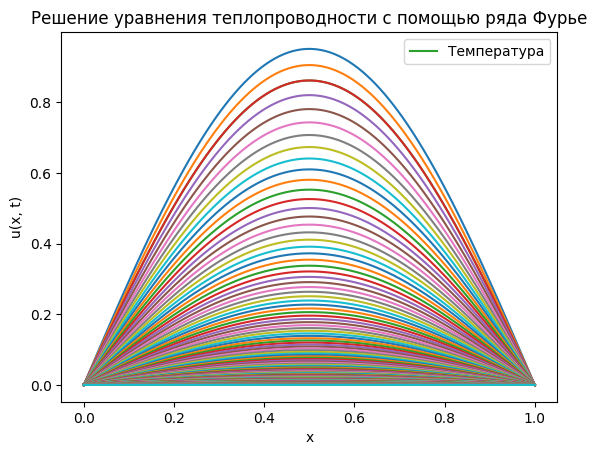

In [41]:
# добавить график максимальной погрешности от шага

import numpy as np
import matplotlib.pyplot as plt

# Параметры задачи
alpha = 0.01  # Коэффициент температуропроводности
L = 1.0       # Длина стержня
T = 1.0       # Время моделирования
Nx = 100      # Количество узлов по пространству
Nt = 1000     # Количество шагов по времени
dx = L / (Nx - 1)  # Шаг по пространству
dt = T / Nt        # Шаг по времени
theta = 0.5        # Весовой коэффициент (0.5 для метода Кранка-Николсона)

# Начальные условия
x = np.linspace(0, L, Nx)
u = np.sin(np.pi * x)  # Начальное распределение температуры

# Матрицы для метода Кранка-Николсона
A = np.zeros((Nx, Nx))
B = np.zeros((Nx, Nx))

# Заполнение матриц A и B
r = alpha * dt / (2 * dx**2)
for i in range(1, Nx-1):
    A[i, i-1] = -r * theta
    A[i, i] = 1 + 2 * r * theta
    A[i, i+1] = -r * theta

    B[i, i-1] = r * (1 - theta)
    B[i, i] = 1 - 2 * r * (1 - theta)
    B[i, i+1] = r * (1 - theta)

# Граничные условия (закрепленные концы)
A[0, 0] = 1
A[-1, -1] = 1
B[0, 0] = 1
B[-1, -1] = 1



for t in range(2):
    for n in range(Nt):
        u_new = np.linalg.solve(A, B @ u)
        u = u_new
    plt.plot(x, u)
# Решение уравнения теплопроводности
for n in range(Nt):
    u_new = np.linalg.solve(A, B @ u)
    u = u_new

# Визуализация результата
plt.plot(x, u, label='Температура')
plt.xlabel('x')
plt.ylabel('u(x, T)')
plt.title('Распределение температуры в момент времени T')
plt.legend()
plt.grid()






x = np.linspace(0, L, Nx)
u = np.sin(np.pi * x)
a = alpha

# Функция f(x, t)
def f(x, t):
    return np.sin(np.pi * x)  # Пример функции f(x, t)

# Решение с помощью ряда Фурье
def fourier_solution(x, t, N_terms=10):
    u_fourier = np.zeros_like(x)
    for n in range(1, N_terms + 1):
        lambda_n = (n * np.pi / L)**2
        integral = (2 / L) * np.trapezoid(u * np.sin(n * np.pi * x / L), x)
        u_fourier += integral * np.sin(n * np.pi * x / L) * np.exp(-a**2 * lambda_n * t)
    return u_fourier

# Визуализация результата
t_values = np.array(list(range(150, 10000, 50)))
for t in t_values:
    u_fourier = fourier_solution(x, t)
    plt.plot(x, u_fourier)

plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('Решение уравнения теплопроводности с помощью ряда Фурье')
plt.legend()
plt.grid()
plt.show()

# uu = np.copy(u)

# f = False
# tmp = []
# for t in t_values:
#     for n in range(Nt * 1):
#         u_new = np.linalg.solve(A, B @ uu)
#         uu = u_new
#     u_fourier = fourier_solution(x, (t - 100)) - uu
#     #plt.plot(x, fourier_solution(x, (t - 100)), label=f'four={t:.2f}')
#     #plt.plot(x, uu, label=f'rug={t:.2f}')
#     #plt.plot(x, u_fourier, label=f'dif={t:.2f}')
#     tmp.append(np.linalg.norm(u_fourier))
# plt.plot(t_values, tmp)


# plt.xlabel('x')
# plt.ylabel('u(x, t)')
# plt.title('Разность решений двумя методами')
# plt.legend()
# plt.grid()
# plt.show()




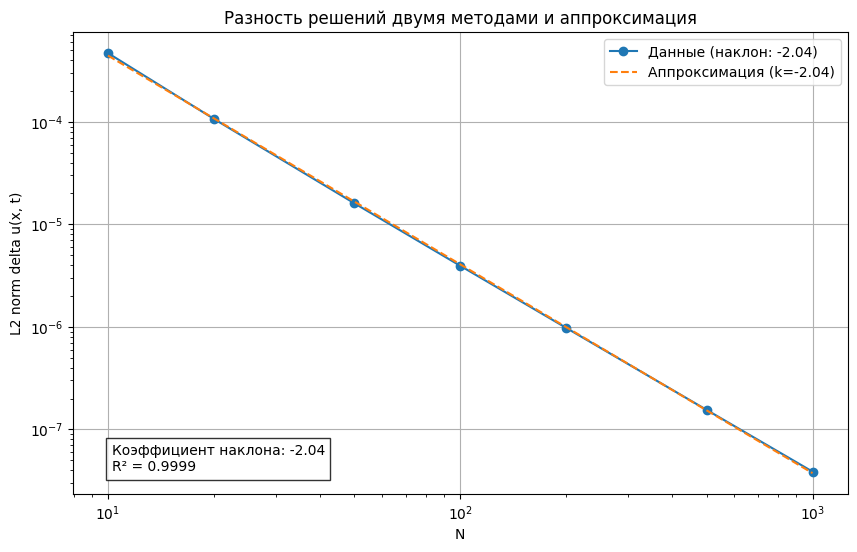

In [42]:
# добавить график максимальной погрешности от шага

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

NX = [10, 20, 50, 100, 200, 500, 1000]

tmp = []
for Nx in NX:
    # Параметры задачи
    alpha = 0.01  # Коэффициент температуропроводности
    L = 1.0       # Длина стержня
    T = 1.0       # Время моделирования
    Nt = 1000     # Количество шагов по времени
    dx = L / (Nx - 1)  # Шаг по пространству
    dt = T / Nt        # Шаг по времени
    theta = 0.5        # Весовой коэффициент (0.5 для метода Кранка-Николсона)

    # Начальные условия
    x = np.linspace(0, L, Nx)
    u = np.sin(np.pi * x)  # Начальное распределение температуры

    # Матрицы для метода Кранка-Николсона
    A = np.zeros((Nx, Nx))
    B = np.zeros((Nx, Nx))

    # Заполнение матриц A и B
    r = alpha * dt / (2 * dx**2)
    for i in range(1, Nx-1):
        A[i, i-1] = -r * theta
        A[i, i] = 1 + 2 * r * theta
        A[i, i+1] = -r * theta

        B[i, i-1] = r * (1 - theta)
        B[i, i] = 1 - 2 * r * (1 - theta)
        B[i, i+1] = r * (1 - theta)

    # Граничные условия (закрепленные концы)
    A[0, 0] = 1
    A[-1, -1] = 1
    B[0, 0] = 1
    B[-1, -1] = 1

    # Решение уравнения теплопроводности
    x = np.linspace(0, L, Nx)
    u = np.sin(np.pi * x)
    a = alpha

    # Функция f(x, t)
    def f(x, t):
        return np.sin(np.pi * x)  # Пример функции f(x, t)

    # Решение с помощью ряда Фурье
    def fourier_solution(x, t, N_terms=10):
        u_fourier = np.zeros_like(x)
        for n in range(1, N_terms + 1):
            lambda_n = (n * np.pi / L)**2
            integral = (2 / L) * np.trapezoid(u * np.sin(n * np.pi * x / L), x)
            u_fourier += integral * np.sin(n * np.pi * x / L) * np.exp(-a**2 * lambda_n * t)
        return u_fourier

    uu = np.copy(u)

    f = False
    if 1:
        for n in range(Nt):
            u_new = np.linalg.solve(A, B @ uu)
            uu = u_new
        u_fourier = fourier_solution(x, 50) - uu
        tmp.append(np.max(np.abs(u_fourier)))

# Преобразуем в numpy массивы для удобства
NX_arr = np.array(NX)
tmp_arr = np.array(tmp)

# Линейная регрессия в логарифмических координатах
log_NX = np.log(NX_arr)
log_tmp = np.log(tmp_arr)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_NX, log_tmp)

plt.figure(figsize=(10, 6))
plt.plot(NX, tmp, 'o-', label=f'Данные (наклон: {slope:.2f})')

# Добавим линию тренда
trendline = np.exp(intercept) * NX_arr**slope
plt.plot(NX_arr, trendline, '--', label=f'Аппроксимация (k={slope:.2f})')

plt.yscale('log')
plt.xscale('log')

plt.xlabel('N')
plt.ylabel('L2 norm delta u(x, t)')
plt.title('Разность решений двумя методами и аппроксимация')
plt.grid()
plt.legend()

# Выведем информацию о наклоне в текстовом виде
plt.text(0.05, 0.05, f'Коэффициент наклона: {slope:.2f}\nR² = {r_value**2:.4f}',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.show()

In [43]:
# a = alpha

# # Функция f(x, t)
# def f(x, t):
#     return np.sin(np.pi * x)  # Пример функции f(x, t)

# # Решение с помощью ряда Фурье
# def fourier_solution(x, t, N_terms=10):
#     u_fourier = np.zeros_like(x)
#     for n in range(1, N_terms + 1):
#         lambda_n = (n * np.pi / L)**2
#         integral = (2 / L) * np.trapezoid(u * np.sin(n * np.pi * x / L), x)
#         u_fourier += integral * np.sin(n * np.pi * x / L) * np.exp(-a**2 * lambda_n * t)
#     return u_fourier

# # Визуализация результата
# t_values = np.linspace(0, T * 1000, 5)
# for t in t_values:
#     u_fourier = fourier_solution(x, t)
#     plt.plot(x, u_fourier, label=f't={t:.2f}')

# plt.xlabel('x')
# plt.ylabel('u(x, t)')
# plt.title('Решение уравнения теплопроводности с помощью ряда Фурье')
# plt.legend()
# plt.grid()
# plt.show()

In [44]:
# for t in t_values:
#     u_fourier = fourier_solution(x, t * 10) - u
#     plt.plot(x, u_fourier, label=f't={t:.2f}')
#     for n in range(Nt):
#         u_new = np.linalg.solve(A, B @ u)
#         u = u_new
# plt.xlabel('x')
# plt.ylabel('u(x, t)')
# plt.title('Разность решений двумя методами')
# plt.legend()
# plt.grid()
# plt.show()



# Лаба 3

In [45]:
# # Схема Лакса Вендрова(Лакса Вендров???)

# import numpy as np
# import matplotlib.pyplot as plt

# def initial_condition(x):
#     return np.exp(-x**2)

# def solve_scheme(scheme, x, t_max, tau, h, a):
#     Nx = len(x)
#     Nt = int(t_max / tau)
#     u = np.zeros((Nt + 1, Nx))
#     u[0, :] = initial_condition(x)

#     if scheme == 1:
#         for n in range(Nt):
#             u[n+1, 1:] = u[n, 1:] - (a * tau / h) * (u[n, 1:] - u[n, :-1])
#             u[n+1, 0] = u[n, 0]  # Граничное условие
#     elif scheme == 2:
#         for n in range(Nt):
#             u[n+1, 1:-1] = u[n, 1:-1] + (a * tau / h) * (u[n, 2:] - u[n, 1:-1])
#             u[n+1, 0] = u[n, 0]  # Граничное условие
#             u[n+1, -1] = u[n, -1]
#     elif scheme == 3:
#         for n in range(Nt):
#             u[n+1, 1:-1] = u[n, 1:-1] - (a * tau / (2*h)) * (u[n, 2:] - u[n, :-2])
#             u[n+1, 0] = u[n, 0]  # Граничное условие
#             u[n+1, -1] = u[n, -1]
#     elif scheme == 4:
#         for n in range(Nt):
#             u[n+1, 1:-1] = (u[n, :-2] + u[n, 2:]) / 2 - (a * tau / h) * (u[n, 2:] - u[n, 1:-1])
#             u[n+1, 0] = u[n, 0]  # Граничное условие
#             u[n+1, -1] = u[n, -1]

#     return u

# # Параметры
# x_min, x_max = -10, 10
# Nx = 100
# h = (x_max - x_min) / Nx
# x = np.linspace(x_min, x_max, Nx)
# a = 1
# tau = 0.01
# times = [0, 1, 2, 3]

# # Визуализация
# plt.figure(figsize=(10, 6))
# schemes = {1: "I", 2: "II", 3: "III", 4: "IV"}
# for scheme in schemes:
#     plt.subplot(2, 2, scheme)
#     plt.title(f"Схема {schemes[scheme]}")
#     for t in times:
#         u = solve_scheme(scheme, x, t, tau, h, a)
#         plt.plot(x, u[int(t / tau), :], label=f"t={t}")
#     plt.legend()
# plt.tight_layout()
# plt.show()


## Лаба 3

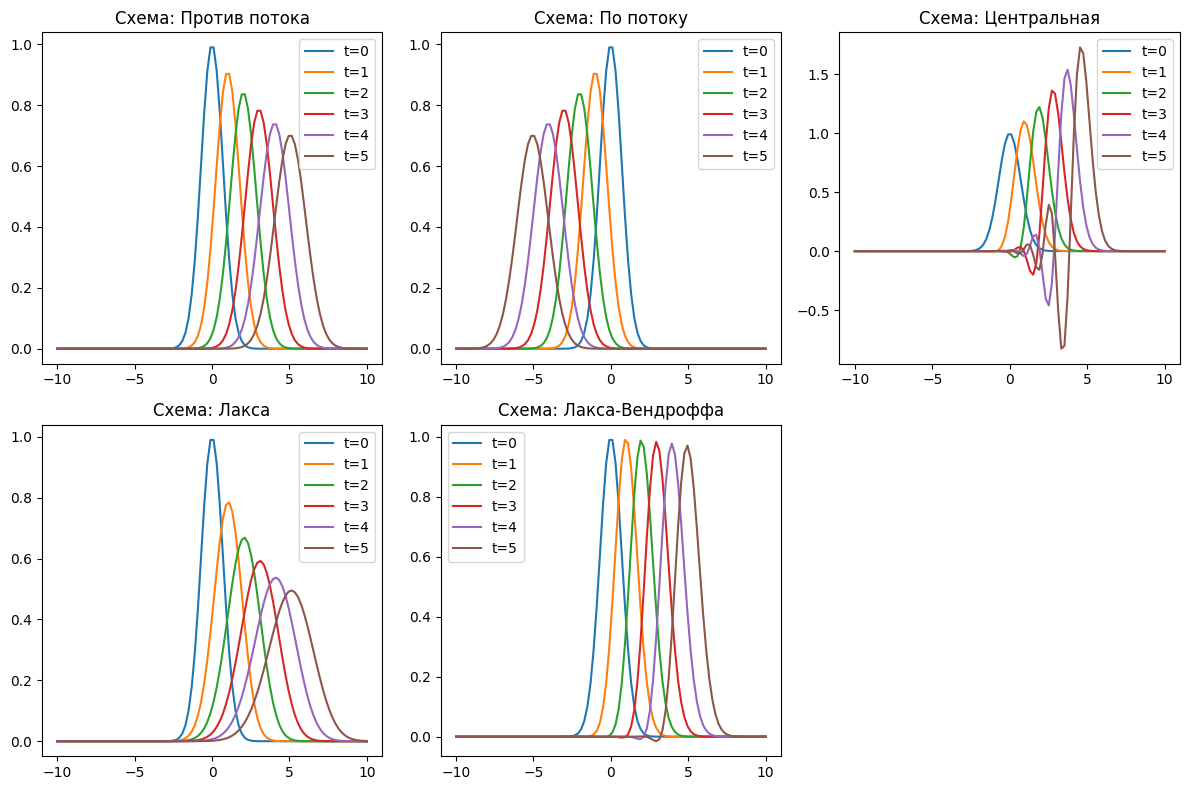

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def initial_condition(x):
    return np.exp(-x**2)

def solve_scheme(scheme, x, t_max, tau, h, a):
    Nx = len(x)
    Nt = int(t_max / tau)
    u = np.zeros((Nt + 1, Nx))
    u[0, :] = initial_condition(x)

    if scheme == 1:  # Против потока
        for n in range(Nt):
            u[n+1, 1:] = u[n, 1:] - (a * tau / h) * (u[n, 1:] - u[n, :-1])
            u[n+1, 0] = u[n, 0]  # Граничное условие
    elif scheme == 2:  # По потоку
        for n in range(Nt):
            u[n+1, :-1] = u[n, :-1] + (a * tau / h) * (u[n, 1:] - u[n, :-1])
            u[n+1, -1] = u[n, -1]  # Граничное условие
    elif scheme == 3:  # Центральная разность
        for n in range(Nt):
            u[n+1, 1:-1] = u[n, 1:-1] - (a * tau / (2*h)) * (u[n, 2:] - u[n, :-2])
            u[n+1, 0] = u[n, 0]  # Граничное условие
            u[n+1, -1] = u[n, -1]
    elif scheme == 4:  # Схема Лакса
        for n in range(Nt):
            u[n+1, 1:-1] = 0.5*(u[n, 2:] + u[n, :-2]) - (a * tau / (2*h)) * (u[n, 2:] - u[n, :-2])
            u[n+1, 0] = u[n, 0]  # Граничное условие
            u[n+1, -1] = u[n, -1]
    elif scheme == 5:  # Схема Лакса-Вендроффа
        c = a * tau / h
        for n in range(Nt):
            u[n+1, 1:-1] = u[n, 1:-1] - 0.5*c*(u[n, 2:] - u[n, :-2]) + 0.5*c**2*(u[n, 2:] - 2*u[n, 1:-1] + u[n, :-2])
            u[n+1, 0] = u[n, 0]  # Граничное условие
            u[n+1, -1] = u[n, -1]

    return u

# Параметры
x_min, x_max = -10, 10
# x_min, x_max = 0, np.pi
Nx = 100
h = (x_max - x_min) / Nx
x = np.linspace(x_min, x_max, Nx)
a = 1
tau = 0.1
times = range(6)

# Визуализация
plt.figure(figsize=(12, 8))
schemes = {1: "Против потока", 2: "По потоку", 3: "Центральная", 4: "Лакса", 5: "Лакса-Вендроффа"}
for scheme in schemes:
    plt.subplot(2, 3, scheme)
    plt.title(f"Схема: {schemes[scheme]}")
    for t in times:
        u = solve_scheme(scheme, x, t, tau, h, a)
        plt.plot(x, u[int(t / tau), :], label=f"t={t}")
    plt.legend()
plt.tight_layout()
plt.show()

# Лаба 4


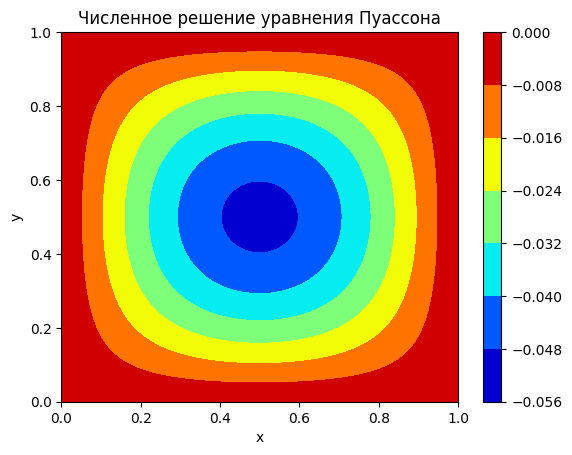

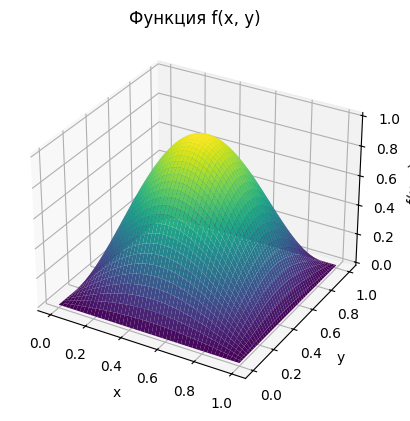

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def solve_poisson(l, N, f, phi1, phi2, phi3, phi4):
    hx = l / (N - 1)
    hy = l / (N - 1)
    u = np.zeros((N, N))

    # Граничные условия
    x = np.linspace(0, l, N)
    y = np.linspace(0, l, N)
    u[:, 0] = phi1(x)   # нижняя граница
    u[:, -1] = phi2(x)  # верхняя граница
    u[0, :] = phi3(y)   # левая граница
    u[-1, :] = phi4(y)  # правая граница

    # Преобразование f(x, y) в сеточный вид
    X, Y = np.meshgrid(x, y, indexing='ij')
    F = f(X, Y)

    # Итерационный метод Якоби
    tol = 1e-6
    max_iter = 10000
    for _ in range(max_iter):
        u_new = np.copy(u)
        for i in range(1, N-1):
            for j in range(1, N-1):
                u_new[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] - hx**2 * F[i, j])

        if np.linalg.norm(u_new - u, ord=np.inf) < tol:
            break
        u = u_new

    return X, Y, u, F

# Функция f
f = lambda x, y: np.sin(np.pi * x) * np.sin(np.pi * y)
# Граничные условия
phi1 = lambda x: np.zeros_like(x)
phi2 = lambda x: np.zeros_like(x)
phi3 = lambda y: np.zeros_like(y)
phi4 = lambda y: np.zeros_like(y)

l = 1
N = 100
X, Y, U, F = solve_poisson(l, N, f, phi1, phi2, phi3, phi4)

# Визуализация решения
plt.contourf(X, Y, U, cmap='jet')
plt.colorbar()
plt.title("Численное решение уравнения Пуассона")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Визуализация f(x, y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, F, cmap='viridis')
ax.set_title("Функция f(x, y)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
plt.show()